# Assignment 2: Transfer Learning

**Overview**

In this assignment, you will explore **transfer learning** for acoustic activity recognition using a pre-trained deep learning model called **Ubicoustics**. You will evaluate the pre-trained model on your own dataset from Assignment 1, perform various fine-tuning experiments with different strategies and hyperparameters, compare the performance to your previous machine learning models, and (optionally) consider how you might use the model in a real-time acoustic recognition application. This assignment builds on the data and insights from Assignment 1, extending your skills into deep learning approaches.

**Note:** This notebook provides step-by-step sections with placeholders for code and analysis. Follow the instructions in each part, fill in the code where prompted, and answer any questions in the provided Markdown cells. By the end, you should have a complete evaluation of transfer learning for your acoustic recognition task.


**Learning Objectives**
1.   Apply transfer learning concepts to an acoustic activity recognition problem.
2.   Evaluate a pre-trained sound recognition model on a custom dataset.
3.   Fine-tune the pre-trained model under different conditions (e.g., different training data and hyperparameters).
4.   Implement and assess a real-time acoustic recognition approach (conceptually or via discussion).
5.   Compare the performance of deep learning vs. traditional machine learning models.

## Setup and Configuration

This section imports necessary libraries and sets up the environment for working with the Ubicoustics model. We'll use VGGish as a feature extractor and load the pre-trained Ubicoustics model to recognize everyday sounds.

In [ ]:
!pip install wget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
import IPython.display as ipd
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
import time
import hashlib
import random
from google.colab import drive
from tqdm.notebook import tqdm
from pathlib import Path
import warnings
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import wget

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except:
    print("Error mounting Google Drive. Please run this cell again.")

# Install required packages if needed


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.


# Ubicoustics Model Loading and Dataset Preparation

In this section, we'll download and load the pre-trained Ubicoustics model. We'll also prepare our dataset from Assignment 1 for evaluation and fine-tuning.

## Ubicoustics Model

The Ubicoustics model is built on top of Google's VGGish audio embedding model. It takes audio spectrograms as input and outputs class probabilities for 30 different everyday sounds.

## VGGish Feature Extraction

VGGish processes audio in the following way:
1. Resamples audio to 16 kHz mono
2. Computes short-time Fourier transform (STFT)
3. Converts to Mel-spectrograms
4. Generates 0.96-second, 96x64 log Mel spectrogram patches

This gives us input with shape (batch_size, 96, 64, 1) for the Ubicoustics model.

In [ ]:
# Download VGGish dependencies (if not already present)
!mkdir -p vggish
!wget -O vggish/vggish_input.py https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_input.py
!wget -O vggish/vggish_params.py https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_params.py
!wget -O vggish/mel_features.py https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/mel_features.py
!wget -O vggish/resampy.py https://raw.githubusercontent.com/bmcfee/resampy/master/resampy/core.py

!pip install resampy

# Import VGGish modules
import sys
sys.path.append('./vggish')
from vggish_input import waveform_to_examples, wavfile_to_examples
import vggish_params

# Configuration
# Your 5 activity classes from Assignment 1
ACTIVITIES = ['laugh', 'cough', 'clap', 'knock', 'alarm']
ENVIRONMENTS = ['small', 'large']
NUM_INSTANCES = 10
SAMPLE_RATE = 16000  # VGGish uses 16kHz

# Ubicoustics labels
UBICOUSTICS_LABELS = {
    'dog-bark':0, 'drill':1, 'hazard-alarm':2, 'phone-ring':3, 'speech':4,
    'vacuum':5, 'baby-cry':6, 'chopping':7, 'cough':8, 'door':9,
    'water-running':10, 'knock':11, 'microwave':12, 'shaver':13, 'toothbrush':14,
    'blender':15, 'dishwasher':16, 'doorbell':17, 'flush':18, 'hair-dryer':19,
    'laugh':20, 'snore':21, 'typing':22, 'hammer':23, 'car-horn':24,
    'engine':25, 'saw':26, 'cat-meow':27, 'alarm-clock':28, 'cooking':29
}

IDX_TO_LABEL = {v: k for k, v in UBICOUSTICS_LABELS.items()}

# Mapping from your 5 activities to Ubicoustics classes
# This maps your activities to the closest Ubicoustics classes
UBICOUSTICS_MAPPING = {
    'laugh': 'laugh',            # Direct match (20)
    'cough': 'cough',            # Direct match (8)
    'clap': 'knock',             # Similar to knock (11) - no exact match for clapping
    'knock': 'knock',            # Direct match (11)
    'alarm': 'hazard-alarm'      # Similar to hazard-alarm (2)
}

# Human-readable labels for display
TO_HUMAN_LABELS = {
    'dog-bark': "Dog Barking", 'drill': "Drill In-Use", 'hazard-alarm': "Hazard Alarm",
    'phone-ring': "Phone Ringing", 'speech': "Person Talking", 'vacuum': "Vacuum In-Use",
    'baby-cry': "Baby Crying", 'chopping': "Chopping", 'cough': "Coughing",
    'door': "Door In-Use", 'water-running': "Water Running", 'knock': "Knocking",
    'microwave': "Microwave In-Use", 'shaver': "Shaver In-Use", 'toothbrush': "Toothbrushing",
    'blender': "Blender In-Use", 'dishwasher': "Dishwasher In-Use", 'doorbell': "Doorbel In-Use",
    'flush': "Toilet Flushing", 'hair-dryer': "Hair Dryer In-Use", 'laugh': "Laughing",
    'snore': "Snoring", 'typing': "Typing", 'hammer': "Hammering", 'car-horn': "Car Honking",
    'engine': "Vehicle Running", 'saw': "Saw In-Use", 'cat-meow': "Cat Meowing",
    'alarm-clock': "Alarm Clock", 'cooking': "Utensils and Cutlery"
}

# Path configuration
BASE_PATH = f"/content/drive/MyDrive"
DATASET_PATH = f"{BASE_PATH}/12481"  # Replace with your dataset ID
MODEL_PATH = f"{BASE_PATH}/models"
CLASS_DATASET_PATH = f"{BASE_PATH}/class_dataset"

# Create necessary directories
os.makedirs(MODEL_PATH, exist_ok=True)

# Load or create your dataset ID
def get_dataset_id():
    # Replace this with your dataset ID from Assignment 1
    # Or uncomment the code below to generate a new one
    return "12481"

    student_name = input("Enter your full name: ")
    hash_object = hashlib.md5(student_name.encode())
    hex_dig = hash_object.hexdigest()
    seed = int(hex_dig, 16) % (10**8)
    random.seed(seed)
    return random.randint(10000, 99999)

dataset_id = get_dataset_id()
DATASET_PATH = f"{BASE_PATH}/{dataset_id}"
print(f"Using dataset path: {DATASET_PATH}")

--2025-05-13 23:18:20--  https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_input.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3536 (3.5K) [text/plain]
Saving to: ‘vggish/vggish_input.py’

vggish/vggish_input 100%[===================>]   3.45K  --.-KB/s    in 0s      

2025-05-13 23:18:20 (52.9 MB/s) - ‘vggish/vggish_input.py’ saved [3536/3536]

--2025-05-13 23:18:20--  https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/vggish/vggish_params.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awai

# A2.1: Evaluating Pre-trained Ubicoustics (5 points)

In this section, you will use the pre-trained Ubicoustics model to classify the audio dataset you collected in Assignment 1. This will serve as a baseline to see how a state-of-the-art acoustic model performs on your specific 5-class problem without any fine-tuning. You will also analyze the results across your two recording environments.

## Instructions:

1.   Make sure your Assignment 1 audio dataset (5 activities × 10 instances × 2 environments = 100 recordings) is available in this notebook. You may need to mount your Google Drive or upload your data so the notebook can access your audio files.
2.   Load the pre-trained Ubicoustics model. (The model file and any necessary helper code are provided in this notebook or via instructions. If a separate download or library is required, follow those instructions here.)
3.   A mapping from the Ubicoustics model's output classes to your 5 activity classes is provided. Use this mapping to convert the model's predictions to your label set. (For example, Ubicoustics might predict many sound classes; you'll map those predictions to the closest of your five classes: cough, laugh, clap, knock, alarm.)
4.   Run the model on each of your audio recordings and obtain the predicted label for each file.
5.   Calculate and report the overall accuracy of the model on your dataset (i.e., the fraction of recordings correctly classified by Ubicoustics).
6.   Compute a confusion matrix for the predictions vs. true labels to see how the model confuses the different activities. This will show which specific activities were correctly or incorrectly recognized.
7.   Compare performance across your two environments: calculate the accuracy on recordings from the small room vs. the large room separately. Determine whether the environment affected the model's performance.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 100 audio files for processing
Running predictions on all audio files...


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/ste

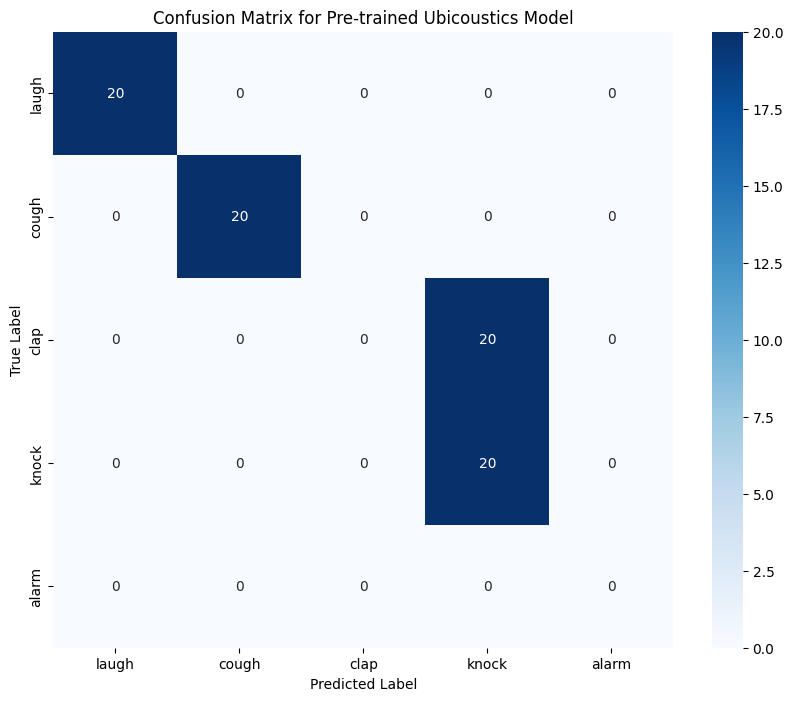

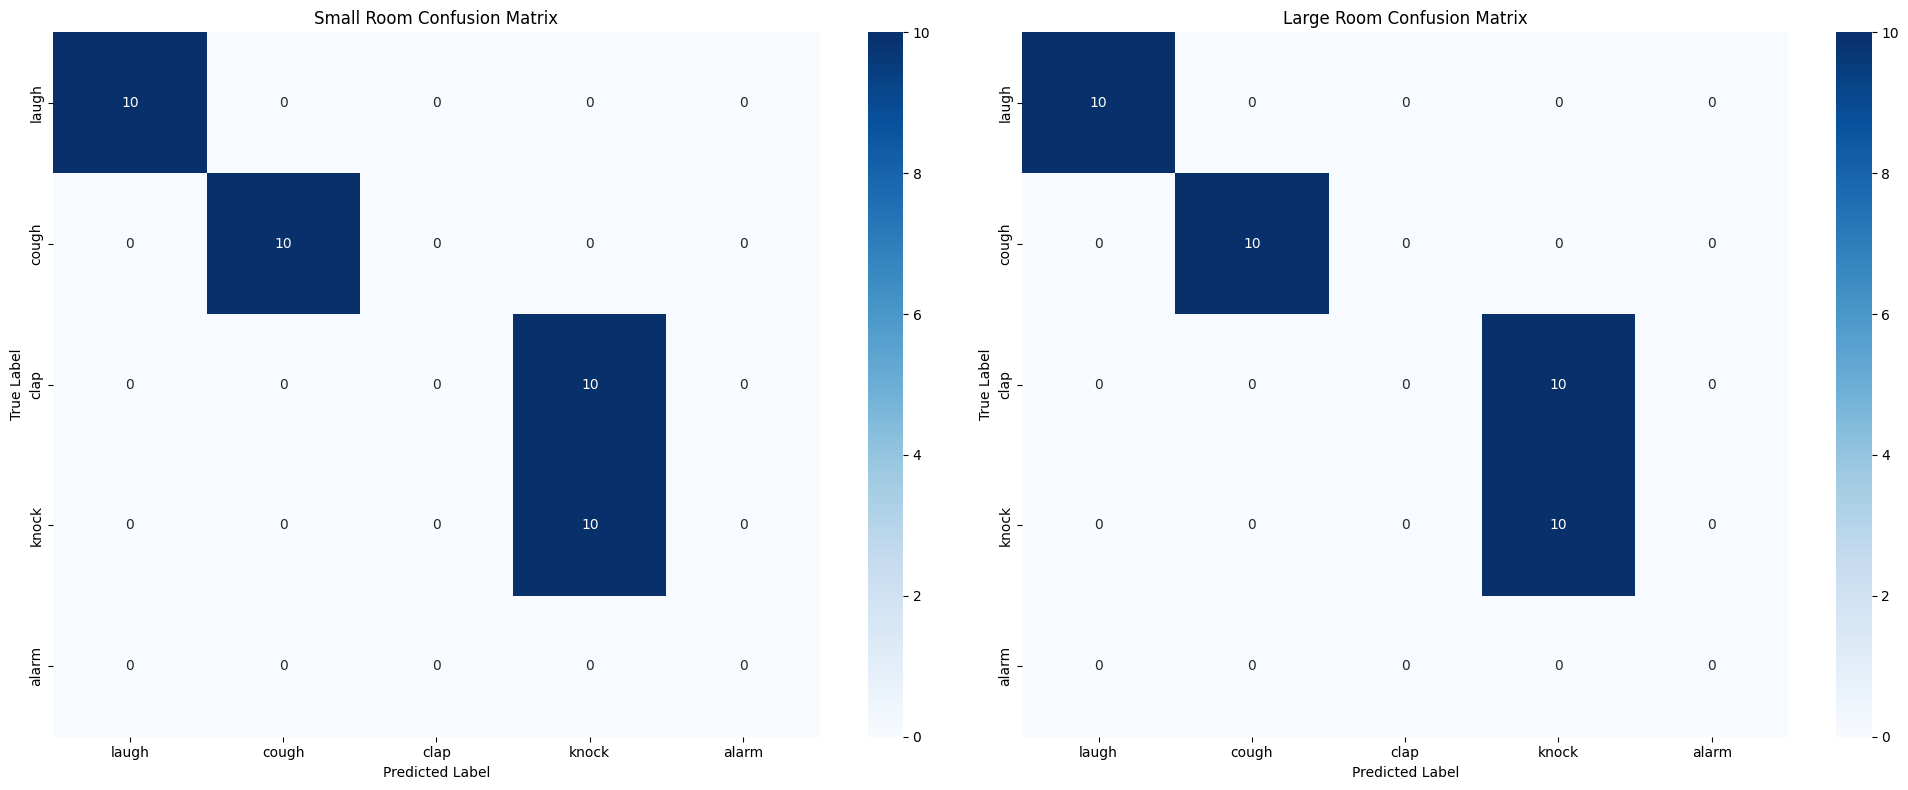

In [ ]:
# Mount Google Drive (directory of your audio data)
from google.colab import drive
drive.mount('/content/drive')


# TODO: Load the pre-trained Ubicoustics model
# For example, if a model file is provided, you might use:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
# model = load_model('ubicoustics_model.h5')
ubicoustics_model_path = f"{MODEL_PATH}/ubicoustics_model.h5"
model = load_model(ubicoustics_model_path, compile=False)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy')


# TODO: Mapping from Ubicoustics classes to your classes
REVERSE_UBICOUSTICS_MAPPING = {
    'laugh': 'laugh',            # Direct match (20)
    'cough': 'cough',            # Direct match (8)
    'knock': 'knock',            # Direct match (11)
    'hazard-alarm': 'alarm'      # Similar to hazard-alarm (2)

}

# TODO: Prepare your data: list all audio file paths and their true labels
audio_files = []    # List of file paths for your 100 audio recordings
true_labels = []    # List of true labels (e.g., 'cough', 'laugh', etc.) for each recording
environments = []   # List of environment labels ('small' or 'large') for each recording (parallel to the files)

if os.path.exists(DATASET_PATH):
    for root, dirs, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith('.wav'):
                # Check if the file follows the naming convention
                file_parts = os.path.splitext(file)[0].split('_')

                # Handle different naming conventions
                if len(file_parts) >= 2:
                    activity = file_parts[0]
                    environment = file_parts[1]

                    # Check if activity and environment are valid
                    if activity in ACTIVITIES and environment in ENVIRONMENTS:
                        audio_files.append(os.path.join(root, file))
                        true_labels.append(activity)
                        environments.append(environment)
                    else:
                        print(f"Skipping {file}: invalid activity or environment")
                else:
                    print(f"Skipping {file}: invalid naming format")

print(f"Found {len(audio_files)} audio files for processing")

def predict_ubicoustics(file_path):
    # Convert audio to VGGish input format
    try:
        # Use librosa to load the audio file instead of direct wavfile_to_examples
        # This is more robust with different audio formats
        y, sr = librosa.load(file_path, sr=vggish_params.SAMPLE_RATE, mono=True)

        # Convert the loaded audio to VGGish examples format
        examples = waveform_to_examples(y, sr)

        if examples.shape[0] == 0:
            print(f"Warning: No examples generated from {file_path}")
            return None

        # Run prediction with Ubicoustics model
        predictions = model.predict(examples)

        # Average predictions across all windows
        avg_pred = np.mean(predictions, axis=0)

        # Get top class
        top_class_idx = np.argmax(avg_pred)

        # Convert to Ubicoustics label
        ubicoustics_labels_reversed = {v: k for k, v in UBICOUSTICS_LABELS.items()}
        predicted_ubicoustics_class = ubicoustics_labels_reversed[top_class_idx]

        # If the predicted class is in your mapping, return it
        # Otherwise, find the closest match
        if predicted_ubicoustics_class in REVERSE_UBICOUSTICS_MAPPING:
            # If there are multiple of your classes mapped to this Ubicoustics class,
            # just choose the first one (this is a simplification)
            return REVERSE_UBICOUSTICS_MAPPING[predicted_ubicoustics_class]
        else:
            # If no direct mapping, return None or some default
            print(f"Warning: No mapping for Ubicoustics class: {predicted_ubicoustics_class}")
            return predicted_ubicoustics_class

    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# TODO: Run the model on each audio file and collect predictions
pred_labels = []
print("Running predictions on all audio files...")

for file_path in tqdm(audio_files):
    prediction = predict_ubicoustics(file_path)
    pred_labels.append(prediction)

# TODO: Calculate and report the overall accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, pred_labels)
print(f"Overall accuracy: {accuracy:.4f}")

# TODO: Compute a confusion matrix for the predictions vs. true labels
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, pred_labels, labels=ACTIVITIES)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Pre-trained Ubicoustics Model')
plt.show()

# report = classification_report(true_labels, pred_labels, labels=ACTIVITIES)
# print("Classification Report:")
# print(report)

# TODO: Compare performance across your two environments:
small_indices = [i for i, env in enumerate(environments) if env == 'small']
large_indices = [i for i, env in enumerate(environments) if env == 'large']

small_true = [true_labels[i] for i in small_indices]
small_pred = [pred_labels[i] for i in small_indices]
large_true = [true_labels[i] for i in large_indices]
large_pred = [pred_labels[i] for i in large_indices]

small_accuracy = accuracy_score(small_true, small_pred)
large_accuracy = accuracy_score(large_true, large_pred)

# Create confusion matrices for each environment
small_cm = confusion_matrix(small_true, small_pred, labels=ACTIVITIES)
large_cm = confusion_matrix(large_true, large_pred, labels=ACTIVITIES)

# Plot confusion matrices for each environment
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(small_cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Small Room Confusion Matrix')

sns.heatmap(large_cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Large Room Confusion Matrix')

plt.tight_layout()
plt.show()

**Discussion:** Describe the performance of the pre-trained model on your dataset in your report.


*   What is the overall accuracy, and is it satisfactory for your needs?
*   Examine the confusion matrix: which activities are most frequently mistaken for one another? Are there specific classes the model struggles with?
*   Compare the accuracy between the two environments. Did the model perform better in the small room or the large room? Why do you think that might be? Consider aspects like background noise or acoustics in each environment.
*   This analysis will serve as a baseline when you later fine-tune the model.

# A2.2: Fine-tuning with Environment-based Cross-validation (5 points)

In this section, we'll fine-tune the Ubicoustics model using environment-based cross-validation. We'll train on data from one environment, test on the other, and reverse the process.

## Instructions:

1. Split your dataset by environment: Create two subsets of your data: one for all recordings in the small room and one for all recordings in the large room. These will serve as two different training/testing sets. For example, when training on the small-room data, the large-room data will be the test set, and vice versa.
2. Fine-tune on one environment: Start by fine-tuning the model using the small-room data as the training set and the large-room data as the test set. Use the Ubicoustics model.
3. Experiment with hyperparameters: Try at least 3 different learning rates (for example: 0.01, 0.001, 0.0001) and 3 different epoch counts (for example: 10, 20, 30 epochs) in your fine-tuning experiments. You can do this systematically (e.g., in a loop) or manually adjust and run multiple times. Keep track of the results for each combination of learning rate and epochs.
4. Swap environments and repeat: After experimenting with training on small-room and testing on large-room, perform the reverse: fine-tune the model using the large-room data as the training set and test on the small-room data. You can use the insights from the first set of experiments to choose a few promising hyperparameter combinations, or systematically try a few options again. Record the accuracy results for these runs as well.
5. Identify the best hyperparameters: Based on your experiments, determine which learning rate and number of epochs gave the highest test accuracy in these cross-environment tests. You might find one combination that consistently works well for both directions, or you might choose one that gives the best average performance across the two scenarios. This will be considered the "optimal" hyperparameter setting for fine-tuning in an environment transfer scenario.
6. Compare to the pre-trained model: Take note of how the fine-tuned model(s) performed versus the original pre-trained model (from A2.1) on the same test sets.

Make sure to document which layers you froze and which you trained in your fine-tuning process (this is important for reporting and for understanding how much of the model was updated during fine-tuning).

In [ ]:
small_indices = [i for i, env in enumerate(environments) if env == 'small']
large_indices = [i for i, env in enumerate(environments) if env == 'large']

small_files = [audio_files[i] for i in small_indices]
small_labels = [true_labels[i] for i in small_indices]
large_files = [audio_files[i] for i in large_indices]
large_labels = [true_labels[i] for i in large_indices]

print(f"Small room dataset: {len(small_files)} files")
print(f"Large room dataset: {len(large_files)} files")

# Define a function to prepare VGGish examples from audio files
def prepare_examples_from_files(file_paths, labels):
    X = []  # Will hold all our audio examples
    y = []  # Will hold integer labels corresponding to activities

    # Map activity names to integer indices
    activity_to_idx = {activity: idx for idx, activity in enumerate(ACTIVITIES)}

    for i, file_path in enumerate(tqdm(file_paths, desc="Processing audio files")):
        try:
            # Load audio
            audio, sr = librosa.load(file_path, sr=vggish_params.SAMPLE_RATE, mono=True)

            # Convert to VGGish format
            examples = waveform_to_examples(audio, sr)

            if examples.shape[0] > 0:  # If we got valid examples
                # Store examples
                X.append(examples)

                # Store the same class index for all examples from this file
                class_idx = activity_to_idx[labels[i]]
                y.append(np.full(examples.shape[0], class_idx))
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")

    # Combine all examples into one array
    if X:
        X = np.vstack(X)
        y = np.concatenate(y)
        return X, y
    else:
        print("No valid examples were generated!")
        return None, None

# Process data for each environment
X_small, y_small = prepare_examples_from_files(small_files, small_labels)
X_large, y_large = prepare_examples_from_files(large_files, large_labels)

print(f"Small room data shape: {X_small.shape}, Labels shape: {y_small.shape}")
print(f"Large room data shape: {X_large.shape}, Labels shape: {y_large.shape}")

Small room dataset: 50 files
Large room dataset: 50 files


Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Small room data shape: (1045, 96, 64), Labels shape: (1045,)
Large room data shape: (1052, 96, 64), Labels shape: (1052,)


In [ ]:
# TODO: Fine-tune model and experiment with different hyperparameters
def create_fine_tuning_model(base_model, num_layers_to_freeze=0):
    """
    Create a model for fine-tuning based on base model.

    Args:
        base_model: Base Ubicoustics model
        num_layers_to_freeze: Number of layers to freeze from the beginning

    Returns:
        Model for fine-tuning
    """
    # Clone the base model
    model = keras.models.clone_model(base_model)
    model.set_weights(base_model.get_weights())

    # Total number of layers
    total_layers = len(model.layers)

    # Freeze layers if specified
    if num_layers_to_freeze > 0:
        # Special case for last layer only
        if num_layers_to_freeze == -1:
            # Freeze all layers except the last one
            for layer in model.layers[:-1]:
                layer.trainable = False
            model.layers[-1].trainable = True
            print(f"Freezing all layers except the last one")
        else:
            # Freeze specified number of layers from the beginning
            for layer in model.layers[:num_layers_to_freeze]:
                layer.trainable = False
            print(f"Freezing {num_layers_to_freeze} layers out of {total_layers}")
    else:
        print("All layers are trainable")

    # Count trainable parameters
    trainable_count = sum(K.count_params(w) for w in model.trainable_weights)
    non_trainable_count = sum(K.count_params(w) for w in model.non_trainable_weights)

    print(f"Total parameters: {trainable_count + non_trainable_count}")
    print(f"Trainable parameters: {trainable_count}")
    print(f"Non-trainable parameters: {non_trainable_count}")

    # Compile model
    model.compile(
        optimizer='adam',  # Will be replaced during fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def fine_tune_model(model, X_train, y_train, X_test, y_test, learning_rate, num_epochs):
    """
    Fine-tune model on given data.

    Args:
        model: Model to fine-tune
        X_train, y_train: Training data
        X_test, y_test: Testing data
        learning_rate: Learning rate for optimization
        num_epochs: Number of training epochs

    Returns:
        Fine-tuned model and training history
    """
    # Create optimizer with specified learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]

    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=num_epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate model
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_acc:.4f}")

    return model, history

In [ ]:
# Function to get file-level predictions from a model
def predict_on_files(model, file_paths, true_labels):
    """
    Get file-level predictions by aggregating window-level predictions

    Args:
        model: The trained model
        file_paths: List of audio file paths to predict on
        true_labels: List of true labels for each file

    Returns:
        List of predicted labels, list of true labels
    """
    # For storing results
    true_file_labels = []
    pred_file_labels = []

    # Map activity names to indices and back
    activity_to_idx = {activity: idx for idx, activity in enumerate(ACTIVITIES)}
    idx_to_activity = {idx: activity for idx, activity in enumerate(ACTIVITIES)}

    # Process each file
    for i, file_path in enumerate(tqdm(file_paths, desc="Predicting on files")):
        try:
            # Get true label
            true_label = true_labels[i]
            true_file_labels.append(true_label)

            # Load and process audio
            audio, sr = librosa.load(file_path, sr=vggish_params.SAMPLE_RATE, mono=True)
            examples = waveform_to_examples(audio, sr)

            if examples.shape[0] > 0:
                # Get predictions for all windows
                window_preds = model.predict(examples)

                # Average predictions across windows
                avg_pred = np.mean(window_preds, axis=0)

                # Get the class with highest average prediction
                pred_idx = np.argmax(avg_pred)
                pred_label = idx_to_activity[pred_idx]

                # Store prediction
                pred_file_labels.append(pred_label)
            else:
                print(f"Warning: No valid examples for {file_path}")
                # If no valid examples, skip this file
                true_file_labels.pop()  # Remove the corresponding true label
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            # If error, skip this file
            true_file_labels.pop()  # Remove the corresponding true label

    return pred_file_labels, true_file_labels

# Modified fine-tuning function that evaluates at file level
def fine_tune_and_evaluate(model, train_files, train_labels, test_files, test_labels,
                          learning_rate, epochs, freeze_all_but_last=False):
    """
    Fine-tune model and evaluate at the file level

    Args:
        model: Base model to fine-tune
        train_files, train_labels: Training data files and labels
        test_files, test_labels: Test data files and labels
        learning_rate, epochs, freeze_all_but_last: Training parameters

    Returns:
        Trained model, test accuracy, and confusion matrix
    """
    X_train, y_train = prepare_examples_from_files(train_files, train_labels)

    clone = keras.models.clone_model(model)
    clone.set_weights(model.get_weights())

    if freeze_all_but_last:
        for layer in clone.layers[:-1]:
            layer.trainable = False
        clone.layers[-1].trainable = True
        print("Freezing all layers except the last one")
    else:
        print("All layers are trainable")

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    clone.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )


    # Use a small portion of training data for validation
    history = clone.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_split=0.1,  # Use 10% of training data for validation
        verbose=1
    )

    pred_labels, true_labels = predict_on_files(clone, test_files, test_labels)

    accuracy = accuracy_score(true_labels, pred_labels)
    cm = confusion_matrix(true_labels, pred_labels, labels=ACTIVITIES)

    print(f"File-level test accuracy: {accuracy:.4f}")

    return clone, accuracy, cm, history

# Run experiments with corrected evaluation
# Initialize results tracking
results = []

# Define the runs you want to try manually
manual_runs = [
    {
        "direction": "large → small",
        "train_files": large_files,
        "train_labels": large_labels,
        "test_files": small_files,
        "test_labels": small_labels,
        "learning_rate": 0.001,
        "epochs": 10,
        "freeze_all_but_last": True,
        "strategy_name": "Last layer only"
    },
]


# Run each manual configuration
for run in manual_runs:
    print(f"\n{run['direction']} | Strategy: {run['strategy_name']} | LR: {run['learning_rate']} | Epochs: {run['epochs']}")

    # Fine-tune and evaluate
    trained_model, accuracy, cm, history = fine_tune_and_evaluate(
        model,
        run['train_files'], run['train_labels'],
        run['test_files'], run['test_labels'],
        run['learning_rate'], run['epochs'],
        run['freeze_all_but_last']
    )

    # Store result
    results.append({
        'direction': run['direction'],
        'strategy': run['strategy_name'],
        'learning_rate': run['learning_rate'],
        'epochs': run['epochs'],
        'accuracy': accuracy
    })

    print(f"{run['direction']}: {run['strategy_name']}, LR={run['learning_rate']}, Epochs={run['epochs']}\nAccuracy: {accuracy:.4f}")


large → small | Strategy: Last layer only | LR: 0.001 | Epochs: 10


Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Freezing all layers except the last one
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.0850 - loss: 21.3467 - val_accuracy: 0.3302 - val_loss: 3.6313
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3059 - loss: 5.0396 - val_accuracy: 0.3396 - val_loss: 3.8469
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7124 - loss: 1.1880 - val_accuracy: 0.6038 - val_loss: 1.6749
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8339 - loss: 0.6966 - val_accuracy: 0.6038 - val_loss: 1.6346
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8684 - loss: 0.5379 - val_accuracy: 0.6604 - val_loss: 1.3737
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8984 - loss: 0.4562 - val_accuracy: 0.7075 - val_loss: 1.1829
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9156 - loss: 0.3292 - val_accuracy: 0.7547 - val_loss: 0.9504
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9318 

Predicting on files:   0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━

**Discussion:** Summarize the outcome of your hyperparameter search in your report.

*   List the test accuracies for the different combinations you tried (you can present this in a brief table or bullet list). Indicate which combination had the highest accuracy for small->large and which had the highest for large->small.
*   Identify your chosen "optimal" hyperparameters (learning rate = ?, epochs = ?). If the optimal differs for the two directions, you can mention both or choose one that seems generally effective.
*   Note which layers you kept trainable during these experiments.

# A2.3: Evaluate on Holdout Dataset (10 points)

In this section, you will fine-tune the Ubicoustics model using **your own collected dataset across both environments** with the best hyperparameters you selected in A2.2. Then, evaluate the model on the **holdout dataset** provided on Dropbox (used in A1). **Do not train on the holdout dataset.**

## Instructions:
After evaluating, compare the model’s performance on the hold-out dataset from:
1. The model you fine-tuned in A2.2.
2. The pre-trained model you evaluated in A2.1.

If the performance of the A2.2 fine-tuned model is worse than A2.1, you may use A2.1 instead.

**Additional improvements:**
- Try different windowing strategies
- Apply noise subtraction or pre-processing
- Filter to use only windows with sound present

You may try different improvement strategies to account for the difficulty of the hold-out dataset (real-world examples), feel free to report what works and what doesn't.

In [ ]:
def load_holdout_data(holdout_data_path):
    """
    Load the holdout dataset, returning file paths and labels with a progress bar.

    Args:
        holdout_data_path (str): Path to the root directory of the holdout dataset.

    Returns:
        tuple: A tuple containing two lists:
            - file_paths (list): List of audio file paths.
            - labels (list): List of labels corresponding to each file.
    """
    file_paths = []
    labels = []

    # Walk through each subdirectory (activity)
    for activity in tqdm(os.listdir(holdout_data_path), desc="Loading data", unit="activity"):
        activity_path = os.path.join(holdout_data_path, activity)

        # Check if it's a directory (it should be, since each directory is labeled with an activity)
        if os.path.isdir(activity_path):
            # Iterate over all files in the subdirectory
            for filename in tqdm(os.listdir(activity_path), desc=f"Processing {activity}", unit="file", leave=False):
                if filename.endswith(".wav"):  # Assuming audio files are .wav format
                    file_path = os.path.join(activity_path, filename)
                    file_paths.append(file_path)
                    labels.append(activity)  # The subdirectory name is the label

    return file_paths, labels

Loading data:   0%|          | 0/5 [00:00<?, ?activity/s]

Processing laugh:   0%|          | 0/5 [00:00<?, ?file/s]

Processing cough:   0%|          | 0/5 [00:00<?, ?file/s]

Processing alarm:   0%|          | 0/5 [00:00<?, ?file/s]

Processing clap:   0%|          | 0/5 [00:00<?, ?file/s]

Processing knock:   0%|          | 0/5 [00:00<?, ?file/s]

Processing audio files:   0%|          | 0/50 [00:00<?, ?it/s]

Freezing all layers except the last one
Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.0964 - loss: 20.8015 - val_accuracy: 0.3019 - val_loss: 3.8999
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.3034 - loss: 4.9480 - val_accuracy: 0.3868 - val_loss: 3.3542
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6965 - loss: 1.4459 - val_accuracy: 0.5472 - val_loss: 1.8548
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8093 - loss: 0.7797 - val_accuracy: 0.6321 - val_loss: 1.4118
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8901 - loss: 0.4139 - val_accuracy: 0.6604 - val_loss: 1.3653
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8916 - loss: 0.4535 - val_accuracy: 0.7358 - val_loss: 0.9861
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9185 - loss: 0.3623 - val_accuracy: 0.7547 - val_loss: 0.9587
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9193 

Predicting on files:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
File-level test accuracy: 0.5200


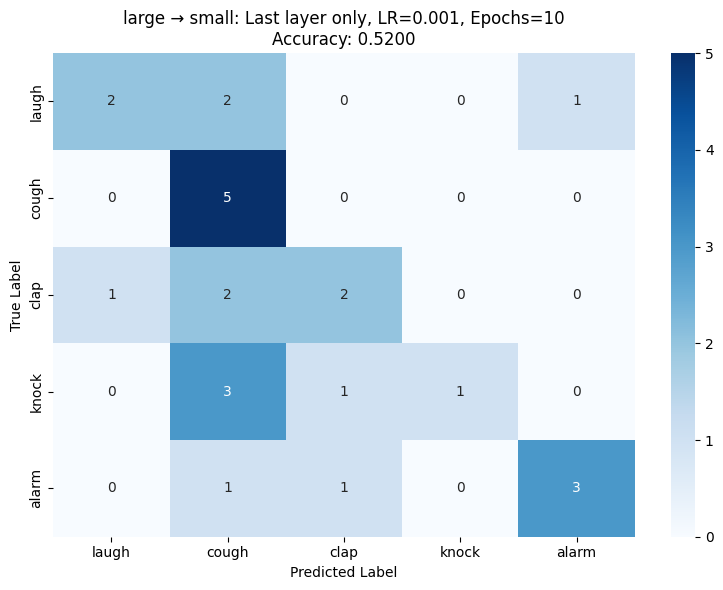

['laugh', 'laugh', 'laugh', 'laugh', 'laugh', 'cough', 'cough', 'cough', 'cough', 'cough', 'alarm', 'alarm', 'alarm', 'alarm', 'alarm', 'clap', 'clap', 'clap', 'clap', 'clap', 'knock', 'knock', 'knock', 'knock', 'knock']
Running predictions on all audio files...


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
0.48


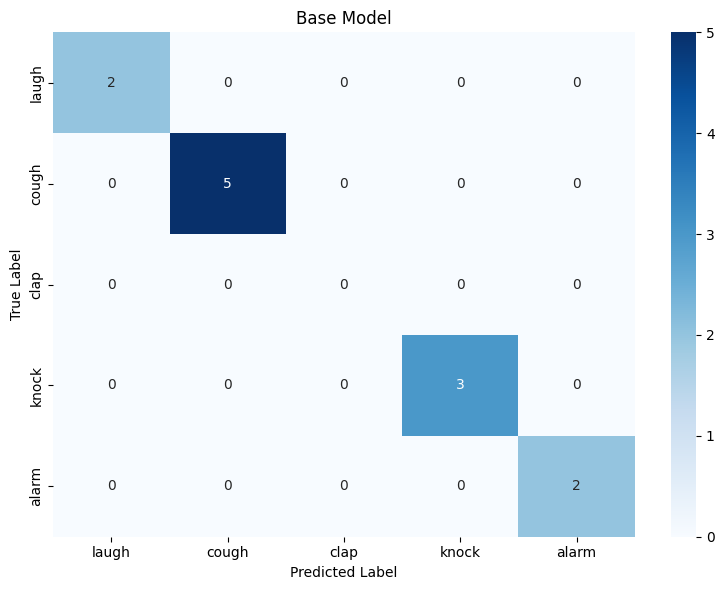

In [ ]:
# TODO: Load the holdout dataset (from A1.6 Dropbox link)
holdout_files = []  # List to store file paths
holdout_labels = []  # List to store true labels

holdout_data_path = '/content/drive/MyDrive/holdout_set'
holdout_files, holdout_labels = load_holdout_data(holdout_data_path)

# TODO: Train on all your collected data using best hyperparameters from A2.2
trained_model, accuracy, cm, history = fine_tune_and_evaluate(
    model,
    train_files=large_files,
    train_labels=large_labels,
    test_files=holdout_files,
    test_labels=holdout_labels,
    learning_rate=0.001,
    epochs=10,
    freeze_all_but_last=True
)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"{run['direction']}: {run['strategy_name']}, LR={run['learning_rate']}, Epochs={run['epochs']}\nAccuracy: {accuracy:.4f}")
plt.tight_layout()
plt.show()

print(holdout_labels)

ubicoustics_model_path = f"{MODEL_PATH}/ubicoustics_model.h5"
base_model = load_model(ubicoustics_model_path, compile=False)
base_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy')

pred_labels = []
print("Running predictions on all audio files...")

for file_path in tqdm(holdout_files):
    prediction = predict_ubicoustics(file_path)
    pred_labels.append(prediction)

accuracy = accuracy_score(holdout_labels, pred_labels)
print(accuracy)
cm = confusion_matrix(holdout_labels, pred_labels, labels=ACTIVITIES)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f"Base Model")
plt.tight_layout()
plt.show()


**Discussion:** In your report:

*   What was the test accuracy on the holdout set?
*   Did the model fine-tuned on your collected data (A2.2) outperform the pre-trained model (A2.1)? If not, which model are you choosing and why?
*   How does this final result compare to your best model from Assignment 1?
*   Which fine-tuning strategy yielded better performance on your data? ("Last layer only" vs "All layers") How big was the difference? What might explain this difference? (If the difference is small, the pre-trained feature extraction might already be well-suited to the task; if the "all layers" is better, it suggests the model could further adapt its internal representations to your data; if "all layers" is worse, perhaps it overfit the combined data or disrupted some of the pre-trained features.)

# Submission

Please ensure you have completed all sections above:

1.   All code placeholders (TODOs) should be filled with working code implementing the required functionality.
2.   All discussion prompts should be answered in your report with your observations and explanations.
3.   Run all cells in order before submission to ensure that the notebook executes without errors from start to finish and that all outputs (accuracies, plots, etc.) are visible.
4.   Save your notebook with the outputs (e.g., in Google Colab go to File > Save a copy in Drive or File > Download .ipynb after running everything).